In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random 
import os
import cv2

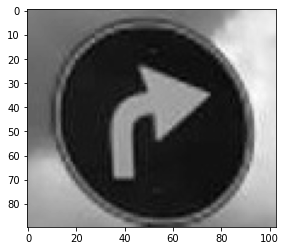

In [2]:
DATADIR = "SagSolDataset"
CATEGORİES = ["Sag", "Sol", "Sagadonulmez", "Soladonulmez"]

for category in CATEGORİES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        plt.show()
        break
    break

In [3]:
print(img_array.shape)

(90, 103)


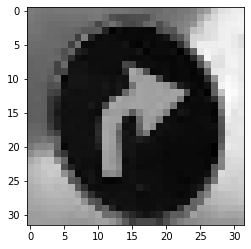

In [4]:
IMG_SIZE = 32 # sabit bir boyut elde etmek adına burada denemeler yapılabilir. Ben 32x32 seçtim çünkü yeterli geldi.

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap="gray")
plt.show()

In [5]:
training_data = []

def create_training_data():
    for category in CATEGORİES:
        path = os.path.join(DATADIR, category) # "SagSolDataset" + "/Sag" gibi bir birleştirme yapıyor.
        class_num = CATEGORİES.index(category) # şuan olduğumuz klasörün adının CATEGORİESteki indeksine bakılarak label belirleniyor.

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) # image i siyah beyaza çeviriyoruz.
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # imagelerin hepsi farklı boyutlarda olduğundan hepsini sabit bir boyuta sabitliyoruz.
                training_data.append([new_array, class_num]) # Veri setini tek bir liste altında image, label olacak şekilde toparlıyoruz.
            except Exception as e:
                pass
            
create_training_data() # yukarıda belirttiğimiz CATEGORİES listesinin indekslerine göre etiketleme işlemi yapıyoruz.
# Veri setinin klasörlenme yapısına bakarsan eğer fonksiyonun basitliğini anlarsın.



In [6]:
X = []
y = []

In [7]:
for features, label in training_data: # imageler ve labeller ayrılıyor ve farklı listelere depolanıyor.
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # DL modelinin bizden istediği format (toplam_data_sayısı, w, h, 1), sondaki 1 aslında channel durumunu belirtiyor.
# biz şu durumda siyah beyaz kullandığımız için 1 olarak belirliyoruz.

In [8]:
# normalization
X = X / 255.0 # 0-255 arası piksel değerlerini 0-1 arasına sıkıştırarak hesaplamadan kaçınıyoruz.

In [9]:
print(X.shape)

(1484, 32, 32, 1)


In [10]:
# Train ve Test verilerini orjinal veri setini dağıtarak elde ediyoruz.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

In [11]:
# Label Encoding - bunu anlamak adına one-hot encoding araştır.
y_train = np.array(y_train)
y_train = to_categorical(y_train, num_classes = 4)

y_test = np.array(y_test)
y_test = to_categorical(y_test, num_classes = 4)

In [12]:
model = Sequential()

# CNN 
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu', input_shape = X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# fully connected
model.add(Flatten())
model.add(Dense(16, activation = "relu"))
model.add(Dense(4, activation = "softmax"))


In [13]:
# Optimizer fonksiyonumuzu seçiyoruz.
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [14]:
# Modelimizi compile ediyoruz.
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [15]:
# Modeli eğitiyoruz.
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
42/42 [==============================] - 2s 7ms/step - loss: 0.7095 - accuracy: 0.7888 - val_loss: 0.2140 - val_accuracy: 0.9664
Epoch 2/5
42/42 [==============================] - 0s 2ms/step - loss: 0.1749 - accuracy: 0.9610 - val_loss: 0.0672 - val_accuracy: 0.9933
Epoch 3/5
42/42 [==============================] - 0s 3ms/step - loss: 0.1027 - accuracy: 0.9783 - val_loss: 0.0364 - val_accuracy: 0.9933
Epoch 4/5
42/42 [==============================] - 0s 3ms/step - loss: 0.0677 - accuracy: 0.9835 - val_loss: 0.0285 - val_accuracy: 1.0000
Epoch 5/5
42/42 [==============================] - 0s 3ms/step - loss: 0.0515 - accuracy: 0.9880 - val_loss: 0.0169 - val_accuracy: 1.0000


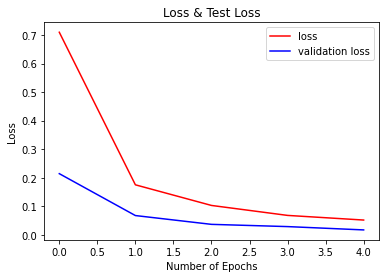

In [16]:
# Eğitim ve test kayıp değerlerinin gösterilmesi
plt.plot(history.history['loss'], color='r', label="loss")
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Loss & Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

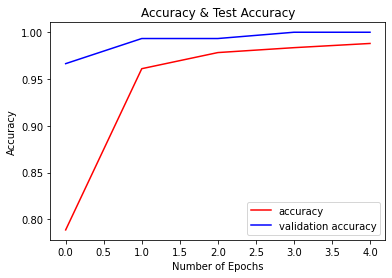

In [17]:
# Eğitim ve test başarım değerlerinin gösterilmesi
plt.plot(history.history['accuracy'], color='r', label="accuracy")
plt.plot(history.history['val_accuracy'], color='b', label="validation accuracy")
plt.title("Accuracy & Test Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

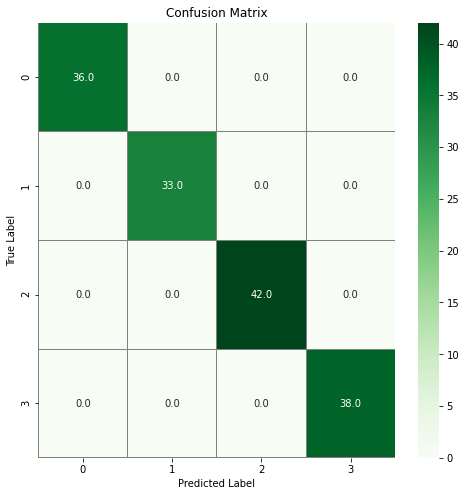

In [18]:
# confusion matrix

# Test verilerinin tahminini yapıyoruz.
y_pred = model.predict(X_test)
# çıkan tahmin sonuçları bir liste şeklinde çıkıyor. örn: [0.233, 0.452, .. ], bunların arasından değeri en büyük olanın indeksi bize sınıfımızı veriyor.
y_pred_classes = np.argmax(y_pred,axis = 1) 
# test etiketlerimizde one hot encode a çevirilmişti. Bu sebeple normale döndürmek adına yukarıdaki ile aynı işlemi yapıyoruz.
y_true = np.argmax(y_test,axis = 1) 
# konfizyon matrisini hesaplatıyoruz.
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# konfizyon matrisini çizdiriyoruz.
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

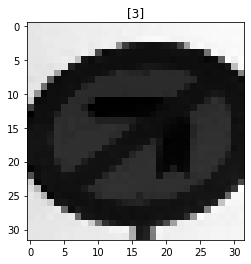

In [19]:
# Tahminler yapmak için image_index i değiştirerek bu cell i çalıştır.

image_index = 222

pred = model.predict(X_train[image_index].reshape(1, X.shape[1], X.shape[2], 1))
pred = np.argmax(pred,axis = 1) 
plt.imshow(X_train[image_index], cmap="gray")
plt.title(f"{pred}") # 0 - sag mecburi, 1 - sol mecburi, 2 - saga dönme, 3 - sola dönme
plt.show()

In [20]:
model.save('SagSolModel.h5') # modeli başka bir kodda çalıştırabilmek adına istediğin bir isimle kayıt et.